In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
directory = os.path.join('./chest_xray/data')

In [6]:
healthy_mris= os.path.join (directory , 'NORMAL')
infected_mris = os.path.join (directory , 'PNEUMONIA')

In [7]:
healthy_files = glob.glob (healthy_mris + '/*.jpeg' ) # Since we have the pictures in the jpeg format
infected_files = glob.glob (infected_mris + '/*.jpeg' )

In [9]:
print ('Total number of Healthy MRI Scans are ' + str (len (healthy_files)))
print ('Total number of Infected MRI Scans are ' + str (len (infected_files)))

Total number of Healthy MRI Scans are 1583
Total number of Infected MRI Scans are 4273


In [13]:
df = pd.DataFrame ({
    'files' : infected_files + healthy_files ,
    'label' : ['infected'] * len (infected_files) + ['healthy'] * len (healthy_files)
     }). sample (frac = 1 , random_state = 0 ). reset_index (drop = True)

In [14]:
df.head(10)

,files,label
0,./chest_xray/data\PNEUMONIA\person884_bacteria...,infected
1,./chest_xray/data\PNEUMONIA\person1839_bacteri...,infected
2,./chest_xray/data\PNEUMONIA\person1271_virus_2...,infected
3,./chest_xray/data\NORMAL\NORMAL2-IM-1258-0001-...,healthy
4,./chest_xray/data\NORMAL\NORMAL2-IM-1258-0001....,healthy
5,./chest_xray/data\PNEUMONIA\person64_virus_122...,infected
6,./chest_xray/data\PNEUMONIA\person1432_bacteri...,infected
7,./chest_xray/data\NORMAL\NORMAL2-IM-0831-0001....,healthy
8,./chest_xray/data\PNEUMONIA\person128_bacteria...,infected
9,./chest_xray/data\PNEUMONIA\person39_virus_85....,infected


In [25]:
# Doing Train- Test Split
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(df['files'].values,
                                                                      df['label'].values, 
                                                                      test_size=0.2, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nValidation Set:', Counter(val_labels), '\n Test Set:', Counter(test_labels))



(4215,) (469,) (1172,)
Train: Counter({'infected': 3078, 'healthy': 1137}) 
Validation Set: Counter({'infected': 340, 'healthy': 129}) 
 Test Set: Counter({'infected': 855, 'healthy': 317})


In [30]:
import cv2
from concurrent import futures
import threading

IMG_DIMS = (200, 200)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  


Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_37: working on img num: 4214

Loading Validation Images:
ThreadPoolExecutor-1_23: working on img num: 0
ThreadPoolExecutor-1_12: working on img num: 468

Loading Test Images:
ThreadPoolExecutor-1_13: working on img num: 0
ThreadPoolExecutor-1_35: working on img num: 1171


((4215, 200, 200, 3), (469, 200, 200, 3), (1172, 200, 200, 3))

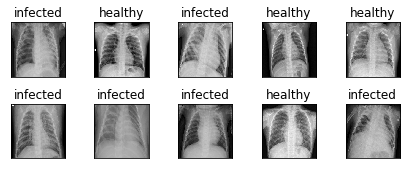

In [31]:
# Visualizing some of the samples in the training data

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (7 , 7))
n = 0 
for i in range(10):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(5 , 5 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [32]:
#Let us now model
import tensorflow as tf
import keras
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.960):
            print("\n Reached 96% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

Using TensorFlow backend.


In [55]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)
test_labels_enc = le.transform (test_labels)

In [40]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.20),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.25),  
  tf.keras.layers.Dense(1, activation='sigmoid')])


In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)           

In [42]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.01),metrics=['acc'])

In [43]:
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

In [44]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=20,
                    epochs=30, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=[callbacks],
                    verbose=2)

Train on 4215 samples, validate on 469 samples
Epoch 1/30
4215/4215 - 162s - loss: 18.8576 - acc: 0.7777 - val_loss: 0.3190 - val_acc: 0.8763
Epoch 2/30
4215/4215 - 164s - loss: 0.8150 - acc: 0.8579 - val_loss: 0.3063 - val_acc: 0.8785
Epoch 3/30
4215/4215 - 163s - loss: 0.8622 - acc: 0.8586 - val_loss: 0.2842 - val_acc: 0.8934
Epoch 4/30
4215/4215 - 154s - loss: 0.9139 - acc: 0.8719 - val_loss: 0.2941 - val_acc: 0.8955
Epoch 5/30
4215/4215 - 153s - loss: 0.4683 - acc: 0.8809 - val_loss: 0.3206 - val_acc: 0.8977
Epoch 6/30
4215/4215 - 157s - loss: 0.8387 - acc: 0.8842 - val_loss: 0.3096 - val_acc: 0.8678
Epoch 7/30
4215/4215 - 157s - loss: 0.4742 - acc: 0.8906 - val_loss: 0.3365 - val_acc: 0.8465
Epoch 8/30
4215/4215 - 152s - loss: 0.6950 - acc: 0.8975 - val_loss: 0.3605 - val_acc: 0.9083
Epoch 9/30
4215/4215 - 147s - loss: 2.0761 - acc: 0.8899 - val_loss: 0.3429 - val_acc: 0.8827
Epoch 10/30
4215/4215 - 150s - loss: 0.5468 - acc: 0.8821 - val_loss: 0.4061 - val_acc: 0.8977
Epoch 11/30

In [45]:
# saving the model weights
model.save('Pneumonia Model.h5')

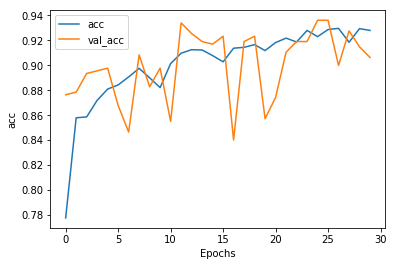

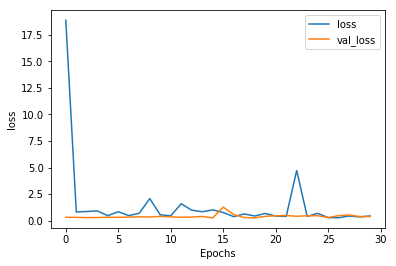

In [46]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' +string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [48]:
from sklearn.metrics import classification_report

In [51]:
y_pred=model.predict(test_data)

In [56]:
target_names = ['Healthy ', 'Pneuometic']
rep=classification_report(test_labels_enc,y_pred,target_names=target_names)

In [57]:
print(rep)

              precision    recall  f1-score   support

    Healthy        0.78      0.36      0.49       317
  Pneuometic       0.80      0.96      0.88       855

   micro avg       0.80      0.80      0.80      1172
   macro avg       0.79      0.66      0.68      1172
weighted avg       0.80      0.80      0.77      1172



In [58]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [59]:
from sklearn.metrics import confusion_matrix

In [62]:
cm=confusion_matrix(test_labels_enc,y_pred )

In [64]:
tn, fp, fn, tp = confusion_matrix(test_labels_enc, y_pred).ravel()

In [65]:
(tn, fp, fn, tp)

(113, 204, 31, 824)

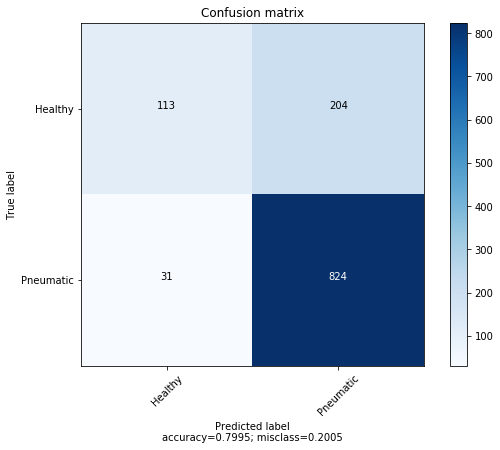

In [68]:
plot_confusion_matrix(cm,normalize=False,target_names=['Healthy','Pneumatic'])

In [88]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(200, 200))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

# Now I will load the weights and do predictions on a couple of examples. The first example should give us a very low probability of having pneumonia and the second example should give us a high probability

In [89]:

from tensorflow.keras.models import load_model

In [90]:
model.load_weights('pn_model.h5')

In [92]:
# image path
img_path = 'a1.jpeg'    
    
    # load a single image
new_image = load_image(img_path)

    # check prediction
pred = model.predict(new_image)

In [93]:
pred

array([[0.06266933]], dtype=float32)

# This prediction shows that the given image has pneumonia with a probability of 0.06266933

In [95]:
img_path = 'a2.jpeg'    
    
    # load a single image
new_image = load_image(img_path)

In [96]:
pred_2 = model.predict(new_image)

In [97]:
pred_2

array([[0.8321454]], dtype=float32)

# This prediction says that probability of this image having pneumonia is 0.8321454